In [2]:
import pandas as pd
import math

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# --- Load your CSV file ---
# ⚠️ Replace "your_file_name.csv" with the actual path to your file.
file_path = "Test.csv"
df = pd.read_csv(file_path)
# -------------------------

print("CSV data loaded successfully from file:")
print(df)

CSV data loaded successfully from file:
                   Name
0              AARTHI S
1             ABIRAMI E
2               AGNES A
3           Ajaykumar R
4     AKSHAY ANIL KUMAR
..                  ...
178    VIJAY KRISHNAN K
179  VIJAYA PRANEETHA A
180       VIKNESWARAN A
181       CHIRANJEEVE R
182   PRAVEEN GAWTHAM.Y

[183 rows x 1 columns]


In [3]:
# Get the number of rows (data items)
N = len(df)
print(f"Number of data entries (N): {N}")

# Compute the number of qubits required to represent N states
num_qubits = math.ceil(math.log2(N))
print(f"Required qubits: {num_qubits}")

Number of data entries (N): 183
Required qubits: 8


In [4]:
# Add a column for the integer row index
df['RowIndex'] = range(N)

# Add a column for the binary representation of the index
df['BinaryIndex'] = df['RowIndex'].apply(lambda x: f'{x:0{num_qubits}b}')

print("DataFrame with binary indices:")
print(df)

DataFrame with binary indices:
                   Name  RowIndex BinaryIndex
0              AARTHI S         0    00000000
1             ABIRAMI E         1    00000001
2               AGNES A         2    00000010
3           Ajaykumar R         3    00000011
4     AKSHAY ANIL KUMAR         4    00000100
..                  ...       ...         ...
178    VIJAY KRISHNAN K       178    10110010
179  VIJAYA PRANEETHA A       179    10110011
180       VIKNESWARAN A       180    10110100
181       CHIRANJEEVE R       181    10110101
182   PRAVEEN GAWTHAM.Y       182    10110110

[183 rows x 3 columns]


In [5]:
# Create a dictionary to map the binary index string back to the row data
binary_to_row_map = {row['BinaryIndex']: row.to_dict() for index, row in df.iterrows()}

print("Mapping from binary index to row data created.")

Mapping from binary index to row data created.


In [6]:
# --- Define your search criteria ---
# ⚠️ CHANGE THESE VALUES to match what you are searching for in your file
target_column = 'Name'
target_value = 'SASIKUMAR R'
# ------------------------------------

# Find the target row in the DataFrame
target_row = df[df[target_column] == target_value]

if not target_row.empty:
    target_index_binary = target_row['BinaryIndex'].iloc[0]
    print(f"Target found: Row where '{target_column}' is '{target_value}'.")
    print(f"Target binary index to search for: |{target_index_binary}⟩")
else:
    raise ValueError(f"Target value '{target_value}' not found in column '{target_column}'.")

Target found: Row where 'Name' is 'SASIKUMAR R'.
Target binary index to search for: |10001110⟩


Oracle circuit constructed.


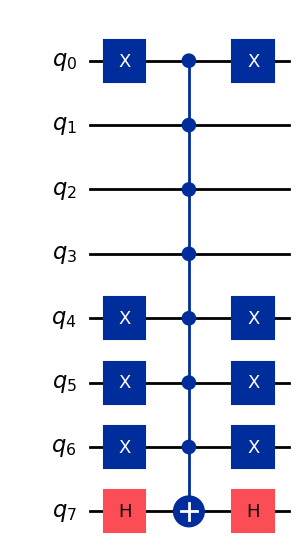

In [7]:
# Create the oracle circuit
oracle = QuantumCircuit(num_qubits, name='Oracle')

# Reverse the target index for Qiskit's bit ordering
reversed_target = target_index_binary[::-1]

# Apply X gates to qubits corresponding to a '0' in the target state
for i, bit in enumerate(reversed_target):
    if bit == '0':
        oracle.x(i)

# Construct the multi-controlled Z-gate using a multi-controlled X-gate (mcx)
# wrapped in Hadamard gates. This marks the target state's phase.
target_qubit = num_qubits - 1
control_qubits = list(range(num_qubits - 1))
oracle.h(target_qubit)
oracle.mcx(control_qubits, target_qubit)
oracle.h(target_qubit)

# Un-compute: Apply X gates again to return to the original state
for i, bit in enumerate(reversed_target):
    if bit == '0':
        oracle.x(i)

# Convert the oracle circuit into a single reusable gate
oracle_gate = oracle.to_gate()

print("Oracle circuit constructed.")
oracle.draw('mpl')

Diffuser circuit constructed.


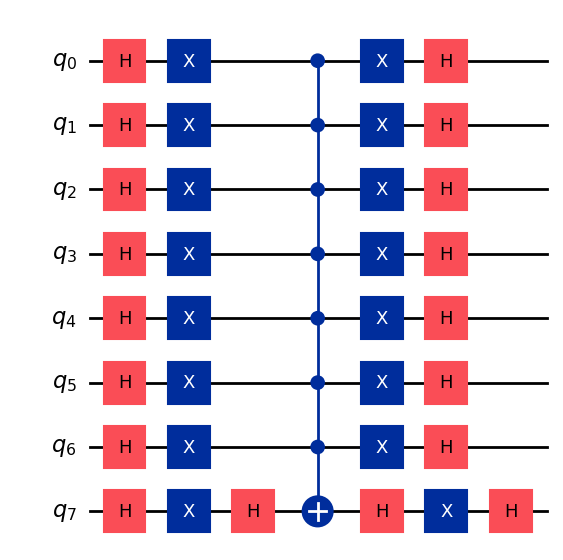

In [8]:
# Create the diffuser (inversion about the mean) circuit
diffuser = QuantumCircuit(num_qubits, name='Diffuser')

# 1. Apply Hadamard gates to all qubits
diffuser.h(range(num_qubits))
# 2. Apply X gates to all qubits
diffuser.x(range(num_qubits))

# 3. Apply a multi-controlled Z gate using the compatible H-MCX-H construction
target_qubit = num_qubits - 1
control_qubits = list(range(num_qubits - 1))
diffuser.h(target_qubit)
diffuser.mcx(control_qubits, target_qubit) # Use .mcx() instead of .mct()
diffuser.h(target_qubit)

# 4. Apply X gates again
diffuser.x(range(num_qubits))
# 5. Apply Hadamard gates again
diffuser.h(range(num_qubits))

# Convert the diffuser circuit into a single gate
diffuser_gate = diffuser.to_gate()

print("Diffuser circuit constructed.")
diffuser.draw('mpl')

Optimal number of Grover iterations: 10
Full Grover circuit assembled.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


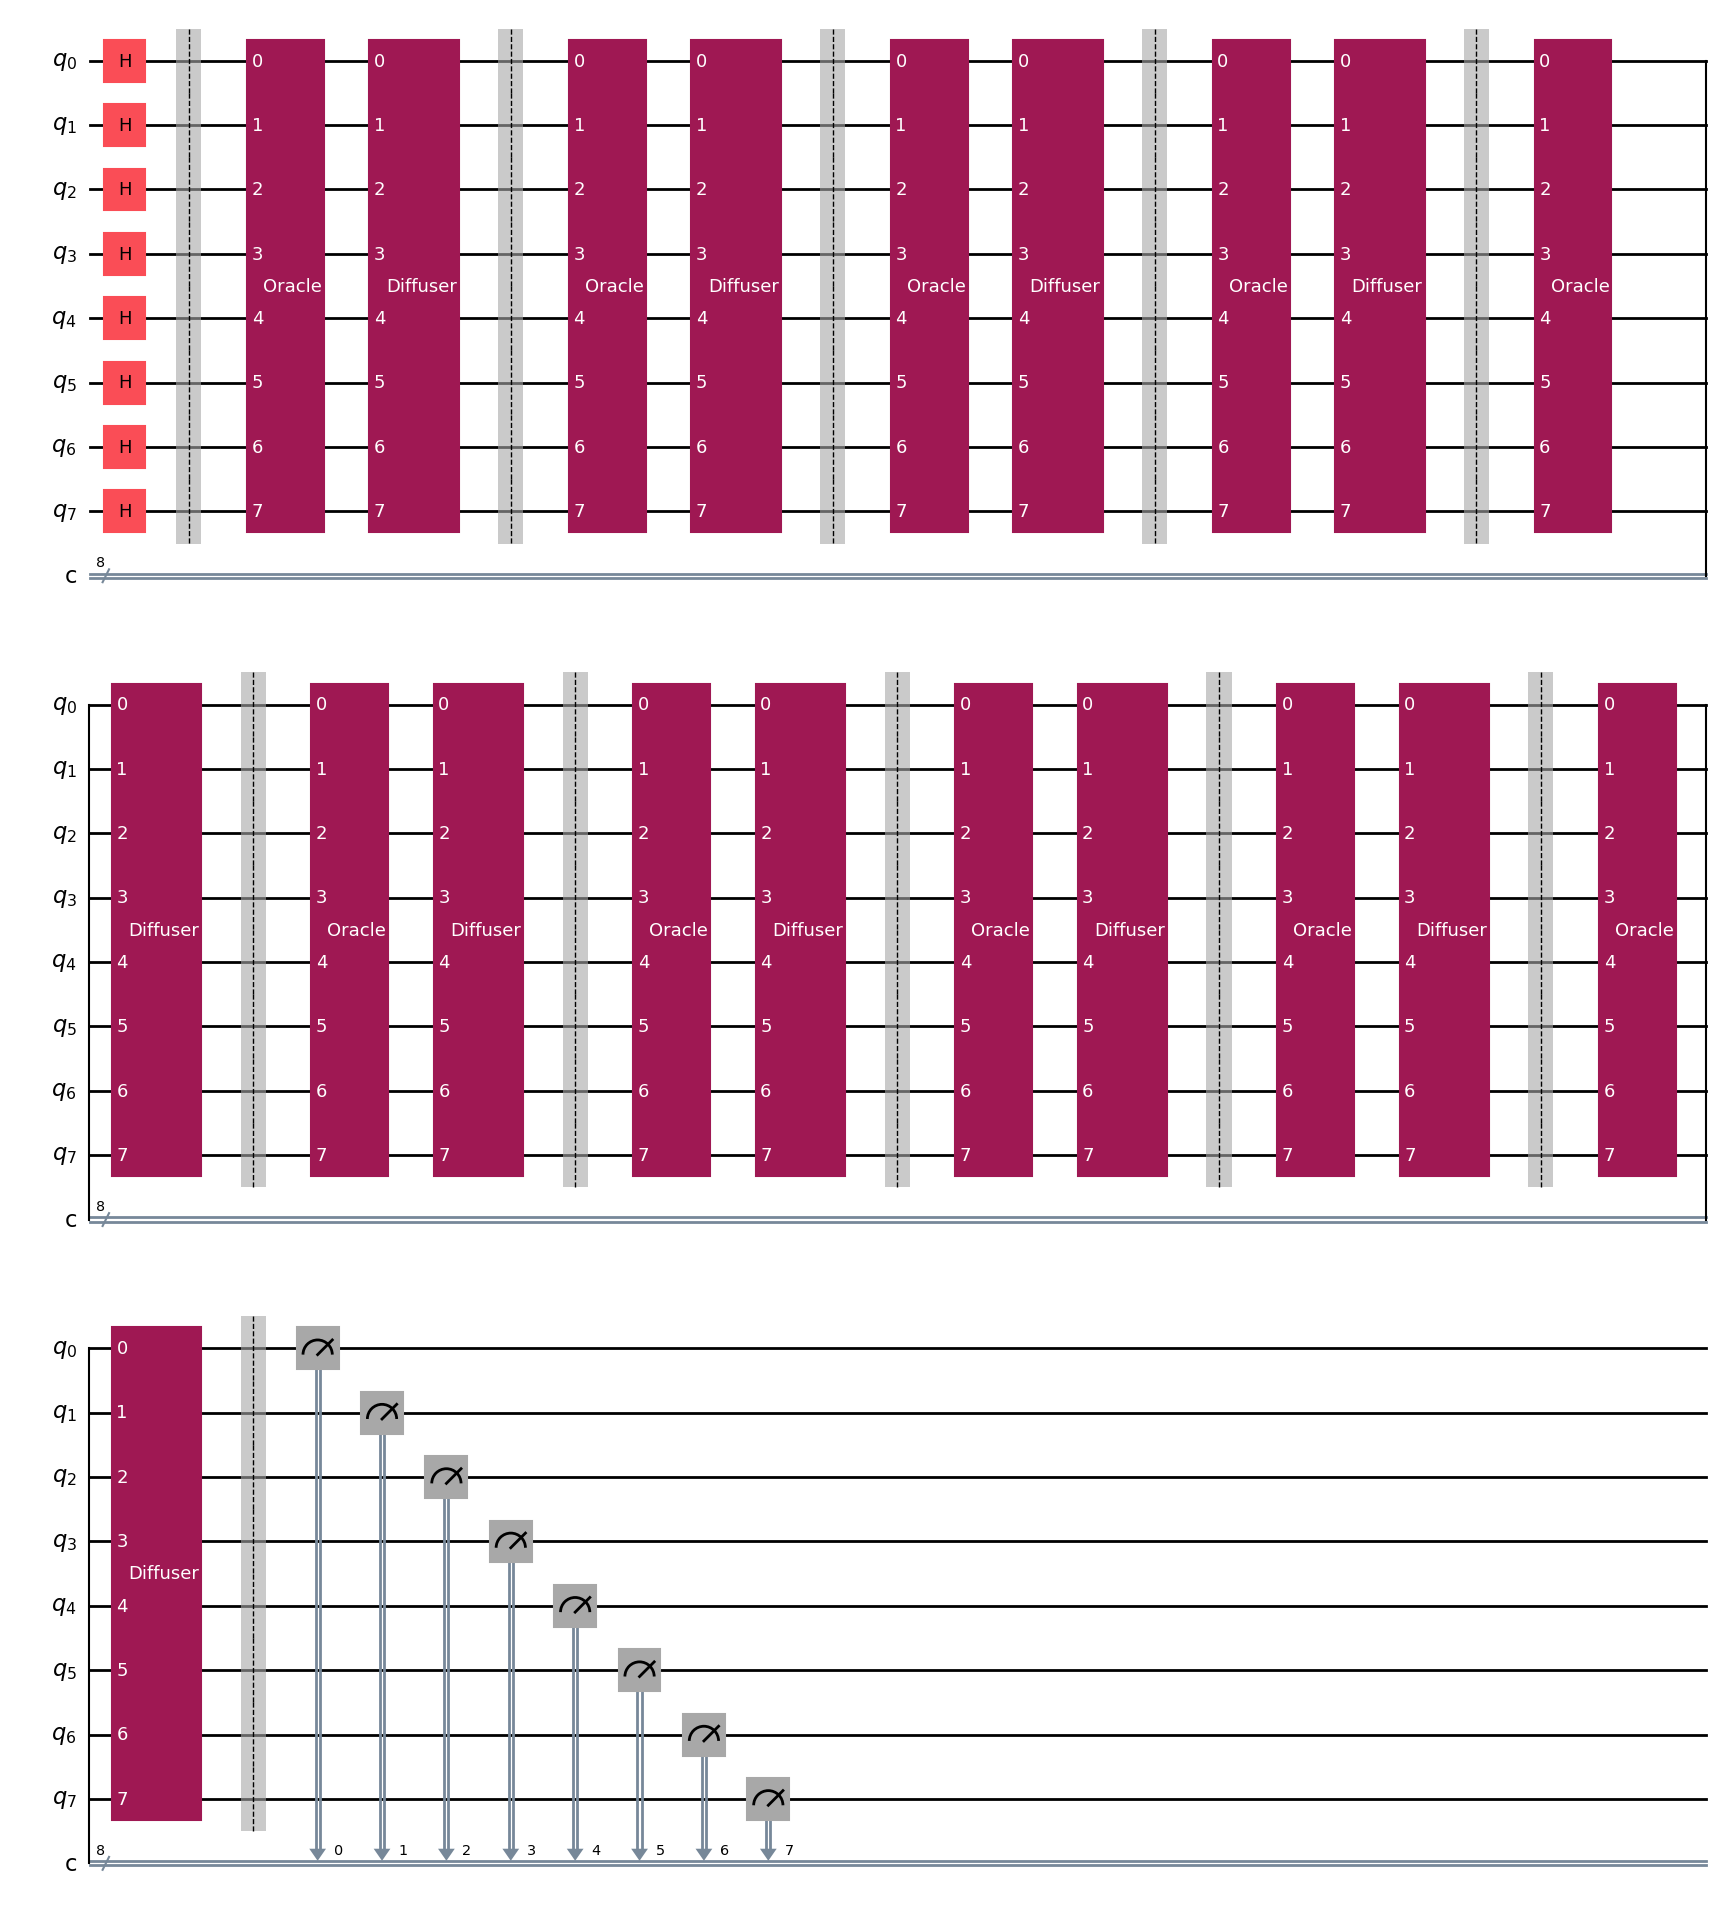

In [9]:
# Calculate the optimal number of Grover iterations
iterations = math.floor(math.pi / 4 * math.sqrt(N))
print(f"Optimal number of Grover iterations: {iterations}")

# Create the main Grover search circuit
grover_circuit = QuantumCircuit(num_qubits, num_qubits)
grover_circuit.name = "Grover's Algorithm"

# 1. Initialize state to uniform superposition
grover_circuit.h(range(num_qubits))
grover_circuit.barrier()

# 2. Apply Grover iterations (Oracle + Diffuser)
for _ in range(iterations):
    grover_circuit.append(oracle_gate, range(num_qubits))
    grover_circuit.append(diffuser_gate, range(num_qubits))
    grover_circuit.barrier()

# 3. Measure the quantum bits
grover_circuit.measure(range(num_qubits), range(num_qubits))

print("Full Grover circuit assembled.")
grover_circuit.draw('mpl', style='iqx')

Simulation complete.
Measurement Counts: {'10000101': 1, '01001110': 1, '01000101': 1, '01010100': 1, '00001100': 1, '11100101': 1, '11000101': 1, '11010100': 1, '10000000': 1, '10010111': 1, '01010111': 1, '10101011': 1, '01000100': 2, '00001000': 1, '10110001': 1, '01010000': 1, '01010101': 1, '00101110': 1, '01101101': 1, '10110100': 1, '10111110': 1, '01101011': 1, '11111110': 1, '11111000': 1, '00011010': 1, '10001000': 1, '10110011': 1, '01100100': 1, '01000011': 1, '01011011': 2, '00011100': 2, '10001110': 970, '11001011': 1, '10111010': 1, '00101001': 1, '11101101': 1, '10101001': 1, '00010010': 1, '11011111': 1, '01110000': 1, '00111101': 1, '01111100': 2, '01110011': 1, '10110101': 1, '00001011': 1, '00111001': 2, '00111000': 1, '00010001': 1, '10110110': 1, '10011001': 1}


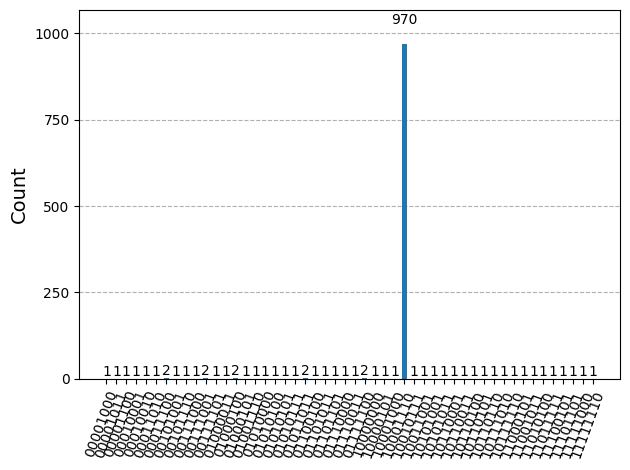

In [10]:
# Set up the Aer simulator
simulator = AerSimulator()

# Transpile the circuit for optimal performance
transpiled_circuit = transpile(grover_circuit, simulator)

# Run the simulation and get the results
result = simulator.run(transpiled_circuit, shots=1024).result()
counts = result.get_counts()

print("Simulation complete.")
print("Measurement Counts:", counts)

# Plot the results
plot_histogram(counts)

In [11]:
# Get the binary string with the highest measurement count
most_frequent_binary = max(counts, key=counts.get)
print(f"Most frequent measurement result: {most_frequent_binary}")

# Map the binary string back to the original CSV row data
found_data = binary_to_row_map[most_frequent_binary]

print("\n---  Quantum Search Result ---")
print(f"Algorithm identified binary index: |{most_frequent_binary}⟩")
print("Corresponding data in the CSV file:")
# Pretty-print the dictionary contents
for key, value in found_data.items():
    print(f"  {key}: {value}")

Most frequent measurement result: 10001110

---  Quantum Search Result ---
Algorithm identified binary index: |10001110⟩
Corresponding data in the CSV file:
  Name: SASIKUMAR R
  RowIndex: 142
  BinaryIndex: 10001110
